This notebook detects IEDs using different parameters.

In [4]:
import mne
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import math
import pyedflib
import random
from tqdm import tqdm
import pandas as pd

matplotlib.rcParams['figure.figsize'] = (10, 2)
mne.set_log_level('WARNING')

%run DetectSpike_SEEG.py

Open the file

## DaKa

In [2]:
# file_name = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'
# file_name = 'Data/TrialPatientArRa/X~ X_2fc7b4bb-d0f1-45b1-b60d-0ec24a942259.EDF'
file_name = 'Data/TrialPatientDaKa/X~ X_0696a934-8738-44ab-8904-99b1d92c4b39.EDF'

f = pyedflib.EdfReader(file_name)

min_min, max_min = 720, 1200

In [10]:
# Load file containing suitable channels and convert to list
df = pd.read_excel('Data/TrialPatientDaKa/Electrodes.xlsx', header=None)
valid_channels = df[0].tolist()

df = pd.read_excel('Data/TrialPatientDaKa/Electrode_mapping.xlsx')

valid_channels_mapped = []
for valid_channel in valid_channels:
    valid_channels_mapped.append("C" + str(int(df[df.Original == valid_channel].Mapped)))
    
signal_labels = f.getSignalLabels()

freq = 2048

In [454]:
# artifact_chans_idx = [46, 47, 49, 51, 52, 53, 57, 59, 98, 99, 113, 137, 146]
# artifact_chans_names = ['C' + str(idx) for idx in artifact_chans_idx]

# valid_channels_mapped_clean = [chan for chan in valid_channels_mapped if chan not in artifact_chans_names]
# valid_channels_clean = [valid_channels[valid_channels_mapped.index(chan)] for chan in valid_channels_mapped_clean]

In [6]:
sample_size = 50
valid_channels_sample = [valid_channels_mapped[i] for i in sorted(random.sample(range(len(valid_channels_mapped)), sample_size))]

In [47]:
from random import randrange

In [7]:
np.save('eeg_samples/sampled_channels.npy', np.array(valid_channels_sample))

In [8]:
np.array(valid_channels_sample)

array(['C2', 'C4', 'C7', 'C8', 'C9', 'C12', 'C17', 'C18', 'C19', 'C20',
       'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C34', 'C35', 'C41',
       'C58', 'C61', 'C62', 'C65', 'C66', 'C73', 'C76', 'C77', 'C80',
       'C81', 'C88', 'C90', 'C96', 'C100', 'C103', 'C107', 'C108', 'C112',
       'C130', 'C131', 'C132', 'C134', 'C135', 'C136', 'C139', 'C140',
       'C145', 'C152', 'C153', 'C154', 'C155'], dtype='<U4')

In [11]:
bh, ah = butter(2, 0.5 / (freq / 2), 'highpass')
bl, al = butter(4, 70 / (freq / 2), 'lowpass')

In [48]:
from pyedflib import EdfWriter, FILETYPE_EDF, FILETYPE_EDFPLUS
from datetime import datetime

start_date = datetime(2017, 5, 24, 15, 53, 49)

def save_eeg(data, valid_channels_sample, filename, all_annotations=None):
    with pyedflib.EdfWriter(filename, len(valid_channels_sample), FILETYPE_EDFPLUS) as writer:
        writer.setPatientCode('')
        writer.setRecordingAdditional('')
        writer.setStartdatetime(start_date)
        writer.setSignalHeaders([{
#             'label': valid_channels[valid_channels_mapped.index(valid_channel)],
            'label': str(i),
            'sample_rate': float(freq),
            'dimension': 'uV',
            'physical_min': -8711.0,
            'physical_max': 8711.0,
            'digital_min': -32767,
            'digital_max': 32767,
            'transducer': '',
            'prefilter': ''
        } for i, valid_channel in enumerate(valid_channels_sample)])
        
        writer.writeSamples(data)
        
        if all_annotations is not None:
            for all_annotation in all_annotations:
                for annotation in all_annotation:
                    # add seconds of index of all_annotation?
                    writer.writeAnnotation(annotation[0], annotation[1], 'IED sequence')
#     writer.close()

In [80]:
spacing = (max_min - min_min) // 100
%run utils.py
combined_data = []
all_annotations = []

for iteration, min_start in enumerate(tqdm(range(min_min, max_min, spacing))):
    
    random.seed(iteration)
    random_start = randrange(0, len(valid_channels_mapped) - sample_size + 1)
#     valid_channels_sample = valid_channels_mapped[random_start:random_start + sample_size]
    valid_channels_sample = valid_channels[random_start:random_start + sample_size]

    data = np.zeros((len(valid_channels_sample), freq * 60))

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels_sample):

        data[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = min_start * freq * 60, \
                                        n = freq * 60)
        
    filename = 'eeg_samples/from_' + str(min_start) + '.edf'
    
    save_eeg(data, valid_channels_sample, filename)
                    
    # Detect IEDs in current block across all chanels
    spike_id, chan_id, _ = DetectSpikes(data, freq, STDCoeff=2)
    
    all_seq_spikes, all_seq_chans = spikes_to_sequences(spike_id, chan_id, 0.015, 0.015)
    
    data = filtfilt(bh, ah, data)
    data = filtfilt(bl, al, data)

    # seconds 1 to 2
    combined_data.append(data[:, 2048:2048*2])
    
    curr_annotations = []
    for all_seq_spike in all_seq_spikes:
        if (1 <= all_seq_spike[0] / 2048 <= 2) or (1 <= all_seq_spike[-1] / 2048 <= 2):
            start = iteration - 1 + all_seq_spike[0] / 2048
            end = iteration - 1 + all_seq_spike[-1] / 2048
            duration = end - start
            curr_annotations.append((start, duration))
            print(start, duration)
        elif all_seq_spike[-1] > 2:
            break
    all_annotations.append(curr_annotations)
    
#     print(len(all_seq_spikes))

 19%|███████▊                                  | 20/107 [00:40<02:56,  2.03s/it]

19.23193359375 0.0


 25%|██████████▌                               | 27/107 [00:56<03:31,  2.65s/it]

26.38330078125 0.0


 45%|██████████████████▊                       | 48/107 [01:40<02:01,  2.07s/it]

47.546875 0.0078125


 61%|█████████████████████████▌                | 65/107 [02:17<01:27,  2.07s/it]

64.12548828125 0.00146484375
64.546875 0.0


 64%|██████████████████████████▋               | 68/107 [02:23<01:20,  2.07s/it]

67.11962890625 0.0


 75%|███████████████████████████████▍          | 80/107 [02:48<00:54,  2.04s/it]

79.23046875 0.001953125
79.7685546875 0.0
79.8779296875 0.0


100%|█████████████████████████████████████████| 107/107 [03:46<00:00,  2.12s/it]


In [82]:
filename = 'eeg_samples/BeSa.edf'
            
save_eeg(np.concatenate(combined_data, axis=-1), valid_channels_sample, filename, all_annotations)

In [75]:
spacing = (max_min - min_min) // 20
%run utils.py
combined_data = []
all_annotations = []

for iteration, min_start in enumerate(tqdm(range(min_min, max_min, spacing))):

    data = np.zeros((len(valid_channels_sample), freq * 60))

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels_sample):

        data[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = min_start * freq * 60, \
                                        n = freq * 60)
        
    filename = 'eeg_samples/BeSa/from_' + str(min_start) + '.edf'
    
    save_eeg(data, valid_channels_sample, filename)
                    
    # Detect IEDs in current block across all chanels
    spike_id, chan_id, _ = DetectSpikes(data, freq, STDCoeff=2)
    
    all_seq_spikes, all_seq_chans = spikes_to_sequences(spike_id, chan_id, 0.05, 0.015)
    
    data = filtfilt(bh, ah, data)
    data = filtfilt(bl, al, data)

    # seconds 1 to 2
    combined_data.append(data[:, 2048:2048*2])
    
    curr_annotations = []
    for all_seq_spike in all_seq_spikes:
        if (1 <= all_seq_spike[0] / 2048 <= 2) or (1 <= all_seq_spike[-1] / 2048 <= 2):
            start = iteration - 1 + all_seq_spike[0] / 2048
            end = iteration - 1 + all_seq_spike[-1] / 2048
            duration = end - start
            curr_annotations.append((start, duration))
            print(start, duration)
        elif all_seq_spike[-1] > 2:
            break
    all_annotations.append(curr_annotations)
    
#     print(len(all_seq_spikes))

  0%|                                                    | 0/20 [00:00<?, ?it/s]


ValueError: 'C3' is not in list

## BeSa

In [73]:
file_name = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'

f = pyedflib.EdfReader(file_name)

min_min, max_min = 720, 2100

In [74]:
# Load file containing suitable channels and convert to list
df = pd.read_excel('Data/TrialPatientBeSa/BeSA/sub-01/Electrodes.xlsx', header=None)
valid_channels = ['EEG ' + name for name in df[0].tolist()]

signal_labels = f.getSignalLabels()

In [510]:
sample_size = 50
valid_channels_sample = [valid_channels[i] for i in sorted(random.sample(range(len(valid_channels)), sample_size))]

In [511]:
np.save('eeg_samples/BeSa/sampled_channels.npy', np.array(valid_channels_sample))

In [512]:
np.array(valid_channels_sample)

array(['EEG A8', 'EEG A13', 'EEG B1', 'EEG B2', 'EEG B3', 'EEG B4',
       'EEG B5', 'EEG B7', 'EEG B8', 'EEG B9', 'EEG B10', 'EEG C1',
       'EEG C2', 'EEG C4', 'EEG C5', 'EEG C10', 'EEG C11', 'EEG C12',
       'EEG D2', 'EEG D4', 'EEG D5', 'EEG D7', 'EEG D8', 'EEG D13',
       'EEG F6', 'EEG F13', 'EEG G1', 'EEG G2', 'EEG G3', 'EEG H1',
       'EEG I2', 'EEG K2', 'EEG K3', 'EEG K4', 'EEG K9', 'EEG L5',
       'EEG L11', 'EEG L12', 'EEG L13', 'EEG L14', 'EEG L15', 'EEG L16',
       'EEG M2', 'EEG M8', 'EEG M9', 'EEG M10', 'EEG M12', 'EEG M13',
       'EEG N14', 'EEG N15'], dtype='<U7')

In [514]:
from pyedflib import EdfWriter, FILETYPE_EDF
from datetime import datetime

start_date = datetime(2017, 5, 24, 15, 53, 49)

def save_eeg(data, valid_channels_sample, filename, all_annotations=None):
    with pyedflib.EdfWriter(filename, len(valid_channels_sample), FILETYPE_EDF) as writer:
        writer.setPatientCode('')
        writer.setRecordingAdditional('')
        writer.setStartdatetime(start_date)
        writer.setSignalHeaders([{
            'label': valid_channel,
            'sample_rate': float(freq),
            'dimension': 'uV',
            'physical_min': -8711.0,
            'physical_max': 8711.0,
            'digital_min': -32767,
            'digital_max': 32767,
            'transducer': '',
            'prefilter': ''
        } for valid_channel in valid_channels_sample])
        
        writer.writeSamples(data)
        
#         if all_annotations is not None:
#             for all_annotation in all_annotations:
#                 for annotation in all_annotation:
#                     # add seconds of index of all_annotation?
#                     writer.writeAnnotation(annotation[0], annotation[1], 'IED sequence')
#     writer.close()

In [516]:
spacing = (max_min - min_min) // 20
%run utils.py
combined_data = []
all_annotations = []

for iteration, min_start in enumerate(tqdm(range(min_min, max_min, spacing))):

    data = np.zeros((len(valid_channels_sample), freq * 60))

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels_sample):

        data[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = min_start * freq * 60, \
                                        n = freq * 60)
        
    filename = 'eeg_samples/BeSa/from_' + str(min_start) + '.edf'
    
    save_eeg(data, valid_channels_sample, filename)
                    
    # Detect IEDs in current block across all chanels
    spike_id, chan_id, _ = DetectSpikes(data, freq, STDCoeff=2)
    
    all_seq_spikes, all_seq_chans = spikes_to_sequences(spike_id, chan_id, freq)
    
    data = filtfilt(bh, ah, data)
    data = filtfilt(bl, al, data)

    # seconds 1 to 2
    combined_data.append(data[:, 2048:2048*2])
    
    curr_annotations = []
    for all_seq_spike in all_seq_spikes:
        if (1 <= all_seq_spike[0] / 2048 <= 2) or (1 <= all_seq_spike[-1] / 2048 <= 2):
            curr_annotations.append((all_seq_spike[0] / 2048, (all_seq_spike[-1] - all_seq_spike[0]) / 2048))
            print(iteration + all_seq_spike[0] / 2048, iteration + all_seq_spike[-1] / 2048)
        elif all_seq_spike[-1] > 2:
            break
    all_annotations.append(curr_annotations)
    
#     print(len(all_seq_spikes))

 25%|███████████                                 | 5/20 [00:12<00:35,  2.39s/it]

5.44970703125 5.44970703125
5.88134765625 5.88134765625


 60%|█████████████████████████▊                 | 12/20 [00:25<00:15,  1.97s/it]

12.8271484375 12.8271484375


 70%|██████████████████████████████             | 14/20 [00:29<00:11,  2.00s/it]

14.58740234375 14.58740234375


 90%|██████████████████████████████████████▋    | 18/20 [00:37<00:04,  2.02s/it]

18.88134765625 18.8818359375


100%|███████████████████████████████████████████| 20/20 [00:41<00:00,  2.09s/it]


In [517]:
filename = 'eeg_samples/BeSa/combined.edf'
            
save_eeg(np.concatenate(combined_data, axis=-1), valid_channels_sample, filename, all_annotations)

Define file specific parameters

In [78]:
freq = 2048

Get channels and number of channels

In [5]:
num_chans = f.signals_in_file  # change to valid_channels.shape[0]
signal_labels = f.getSignalLabels()

Get list of channels to use from channels.mat

In [79]:
# Load file containing suitable channels and convert to list
df = pd.read_excel('Data/TrialPatientDaKa/Electrodes.xlsx', header=None)
valid_channels = df[0].tolist()

df = pd.read_excel('Data/TrialPatientDaKa/Electrode_mapping.xlsx')

valid_channels_mapped = []
for valid_channel in valid_channels:
    valid_channels_mapped.append("C" + str(int(df[df.Original == valid_channel].Mapped)))

In [5]:
# Load file containing suitable channels and convert to list
mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
valid_channels = [channel[0] for channel in mat['channels'][:, 0]]

# valid_channels = signal_labels

In [8]:
import pandas as pd

# Load file containing suitable channels and convert to list
df = pd.read_excel('Data/TrialPatientDaKa/Electrodes.xlsx', header=None)
valid_channels_unmapped = df[0].tolist()

df = pd.read_excel('Data/TrialPatientDaKa/Electrode_mapping.xlsx')

valid_channels = []
for valid_channel in valid_channels_unmapped:
    valid_channels.append("C" + str(int(df[df.Original == valid_channel].Mapped)))

In [53]:
valid_channels_unmapped[valid_channels.index('C47')]

'C5'

Process a random minute of data with a range of params and select random 5s segments in random channels to show detections for each set of params.

In [18]:
matplotlib.rcParams['figure.figsize'] = (2, 2)

235 L12 8


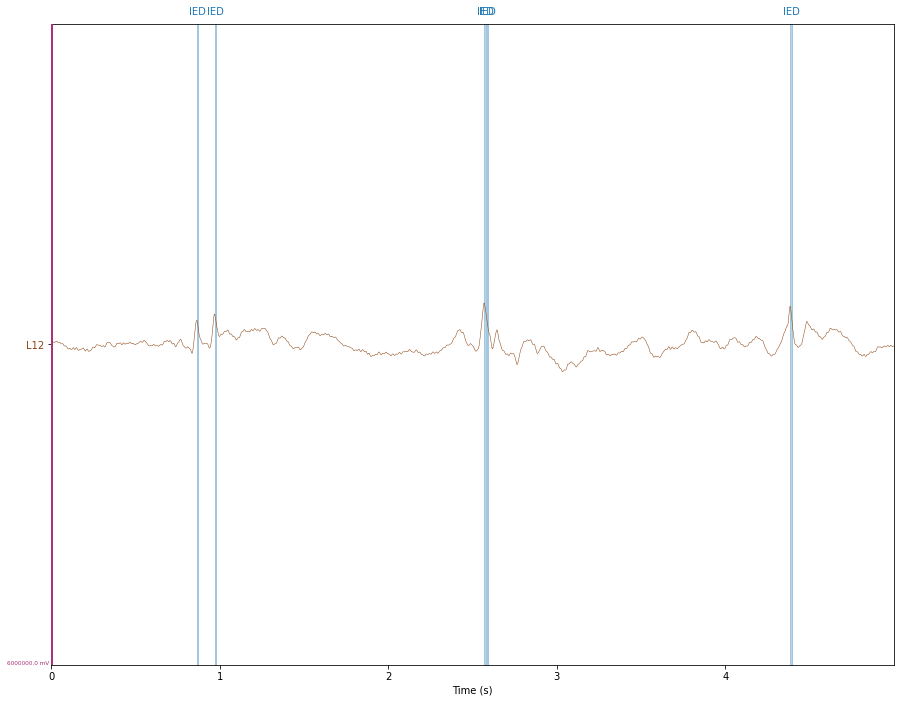

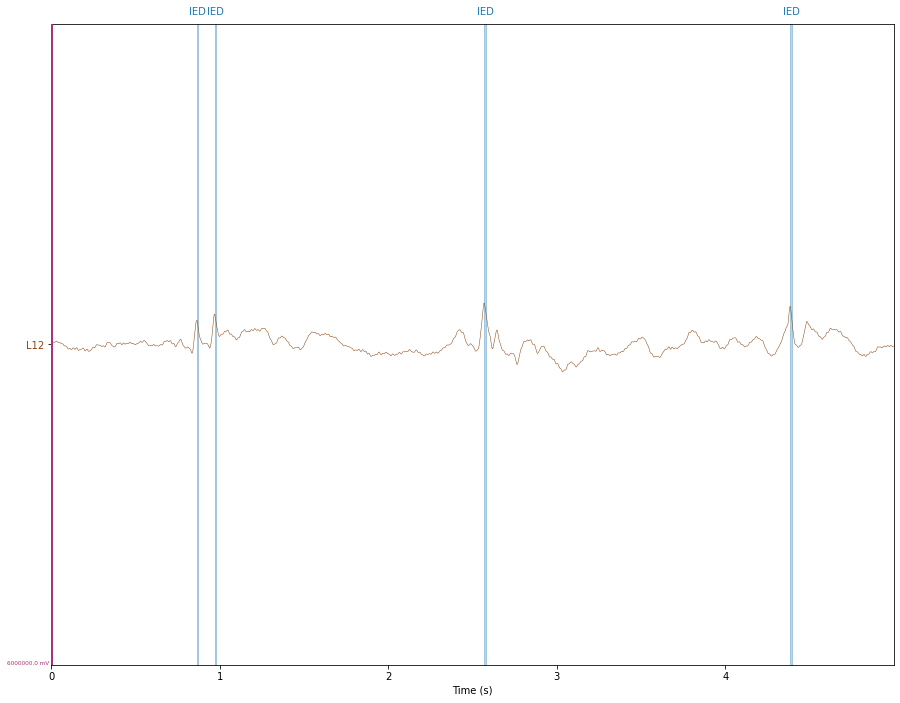

In [92]:
# Process 1 minute at a time
mins_to_process = 1

M = f.getNSamples()[0]# / (freq * 60)

NumSecs = M / freq
Blocks = math.floor(NumSecs / (mins_to_process * 60))

bh, ah = butter(2, 0.5 / (freq / 2), 'highpass')
bl, al = butter(4, 70 / (freq / 2), 'lowpass')
    
def generate_detections(params_list):
    
    # Randomly choose a minute to select data from
    minute = random.randrange(60, Blocks)
    # minute = 28
    
    data_block = np.zeros((len(valid_channels_mapped), freq * 60 * mins_to_process))

#     reference = f.readSignal(signal_labels.index(ref_chan), \
#                              start = minute * freq * 60 * mins_to_process, \
#                              n = freq * 60 * mins_to_process)

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels_mapped):

        data_block[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = minute * freq * 60 * mins_to_process, \
                                        n = freq * 60 * mins_to_process)# - reference
        
    # Index of channel to consider
    chan = random.choices(valid_channels)[0]
    
    # Randomly select a 5 second segment within the minute of data to show detections for (note: 12 blocks of 5s)
    five_second_segment = random.randrange(12)
    
    print(minute, chan, five_second_segment)
    
    for params in params_list:
        # Detect IEDs in current block across all chanels
        SpikeIndex, ChanId, _ = DetectSpikes(data_block, freq, **params)
        
        data = filtfilt(bh, ah, data_block, padlen=150)
        data_block = filtfilt(bl, al, data_block, padlen=150)

        info = mne.create_info([chan], freq, ch_types='seeg')
        data = mne.io.RawArray(data = [data_block[valid_channels.index(chan)] \
                                       [five_second_segment * freq * 5 : \
                                        (five_second_segment + 1) * freq * 5]], info = info)

        onsets = []
        durations = []
        descriptions = []
        
        SpikeIds_from_zero = SpikeIndex - five_second_segment * freq * 5
        spike_indices = np.logical_and(ChanId == valid_channels.index(chan), SpikeIds_from_zero < 5 * freq)
        
        for spike in SpikeIds_from_zero[spike_indices]:
            if spike > 0:
                onsets.append(spike / 2048)
                durations.append(0.01)
                descriptions.append('IED')

        my_annot = mne.Annotations(onset=onsets,  # in seconds
                                   duration=durations,  # in seconds, too
                                   description=descriptions)

        data = data.set_annotations(my_annot)

        # test = data.plot(start=20, duration=2, n_channels=6, scalings=dict(eeg=5e-4))
        fig = data.plot(scalings=dict(seeg=3e3), show_scrollbars=False)

        plt.show()
        
DetThresholds_list = [{'DetThresholds':[7, 7, 200, 10, 10]},
                      {'DetThresholds':[7, 7, 400, 10, 10]},
                      {'DetThresholds':[7, 7, 600, 10, 10]},
                      {'DetThresholds':[7, 7, 800, 10, 10]}]

STDCoeff_list = [2, 3]

SCALE_list = [70]

params1 = {'STDCoeff': 2}
params2 = {'STDCoeff': 3}

# generate_detections(DetThresholds_list)
generate_detections([params1, params2])

Det Thresholds: [7, 7, 600, 10, 10]

7 seems fine for the first two arguments. Definitely not 9. (explored 5-9)

STDCoeff: 3 seems okay (explored 2-6). 2 has less false negatives, but more false positives.

scales of 60-90 so far (explored 50-90). 70 seems good.